# Available data and its quality

In [1]:
source("../setup.R")
library(zoo)

here() starts at /Users/stefan/workspace/work/phd/thesis


Attache Paket: 'zoo'


Die folgenden Objekte sind maskiert von 'package:base':

    as.Date, as.Date.numeric




## RKI data

Warning message:
"Removed 6 rows containing missing values or values outside the scale range
(`geom_line()`)."
Warning message:
"Removed 6 rows containing missing values or values outside the scale range
(`geom_line()`)."


pdf 
  2

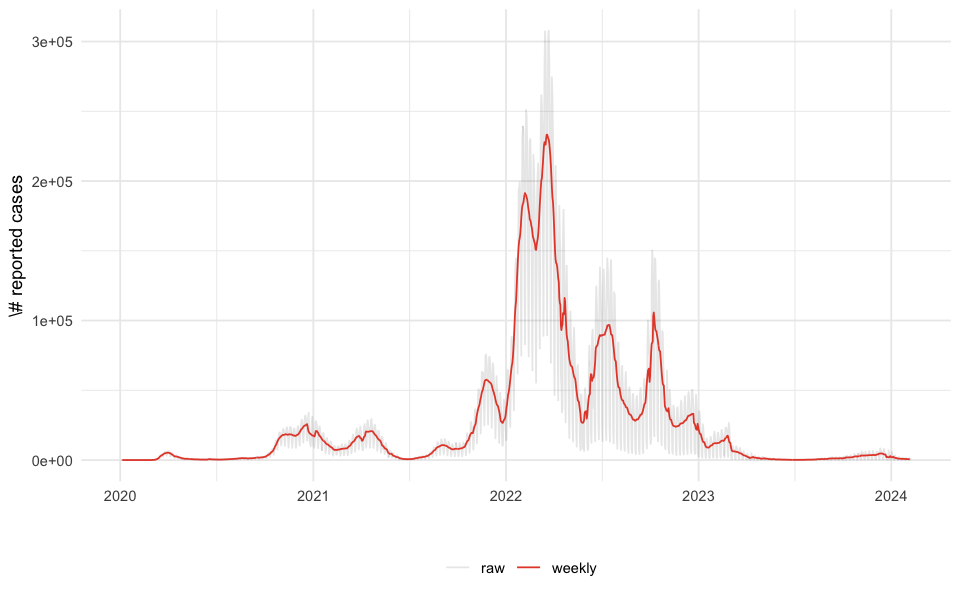

In [5]:
rki_county <- here("data/processed/RKI_county.csv") %>% 
    read_csv()

rki_county %>% 
    group_by(date) %>%
    summarize(cases = sum(cases), deaths = sum(deaths)) %>%
    mutate(cases_7 = rollmean(cases, k = 7, fill = NA)) %>%
    pivot_longer(cols = c(cases, cases_7), names_to = "type", values_to = "value") %>%
    mutate(type = ifelse(type == "cases", "raw", "weekly")) %>%
    ggplot(aes(date, value, color = type, alpha = type)) +
    geom_line() +
    scale_color_manual(values = c("raw" = "black", "weekly" = pal_npg()(1))) +
    scale_alpha_manual(values = c("raw" = .1, "weekly" = 1))  +
    labs(x = "", y = "\\# reported cases", alpha="", color="")  +
    theme(legend.position = "bottom")

ggsave_tikz(here("tikz/cases_germany.tex"))